# リポジトリクローン

In [19]:
!git clone https://github.com/ByungKwanLee/Phantom
%cd Phantom

Cloning into 'Phantom'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 88 (delta 25), reused 82 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 2.38 MiB | 9.48 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/Phantom/Phantom


# パッケージインストール

In [20]:
!pip install -q timm
!pip install -q bitsandbytes
# Flash Attention 対応の Ampereアーキテクチャ採用GPU(L4やA100など)を利用すること
!pip install -q flash-attn --no-build-isolation

# モデル読み込み

In [21]:
from model.load_model import load_model

# モデルサイズ
# '0.5b' (transformers more recent version) | '1.8b' | '3.8b' (transformers==4.37.2) | '7b'
size = '0.5b'

# モデル読み込み
model, tokenizer = load_model(size=size)
for param in model.parameters():
    if not param.is_cuda:
        param.data = param.cuda()

# サンプル画像ダウンロード

In [23]:
!wget https://raw.githubusercontent.com/Kazuhito00/Molmo-Colaboratory-Sample/refs/heads/main/sample.jpg -O test.jpg

--2024-09-27 06:50:08--  https://raw.githubusercontent.com/Kazuhito00/Molmo-Colaboratory-Sample/refs/heads/main/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182906 (179K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 178.62K  --.-KB/s    in 0.003s  

2024-09-27 06:50:08 (64.2 MB/s) - ‘test.jpg’ saved [182906/182906]



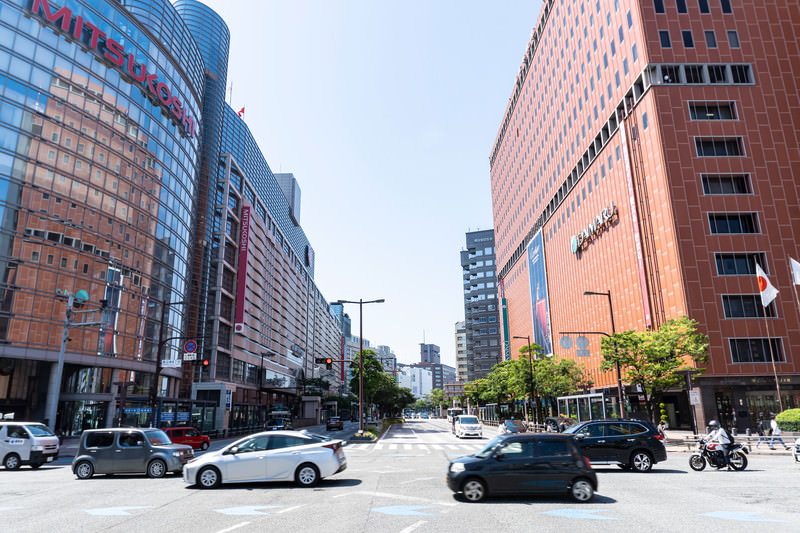

In [24]:
from PIL import Image

pil_image = Image.open('test.jpg')
if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')

pil_image

# 推論

In [25]:
import torch
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

# プロンプト準備
prompt_type = 'with_image'  # 'text_only' or 'with_image'
pil_image  = Image.open('test.jpg').convert('RGB')
question = 'Describe the image in detail'

if prompt_type == 'with_image':
    image = pil_to_tensor(pil_image)
    inputs = [{'image': image, 'question': question}]
elif prompt_type=='text_only':
    inputs = [{'question': question}]

In [26]:
%%time

# 推論
with torch.inference_mode():
    _inputs = model.eval_process(
        inputs=inputs,
        data='demo',
        tokenizer=tokenizer,
        device='cuda:0',
    )
    generate_ids = model.generate(**_inputs, do_sample=False, max_new_tokens=256)
answer = tokenizer.batch_decode(generate_ids, skip_special_tokens=True)[0]

CPU times: user 36.6 s, sys: 63.1 ms, total: 36.6 s
Wall time: 36.5 s


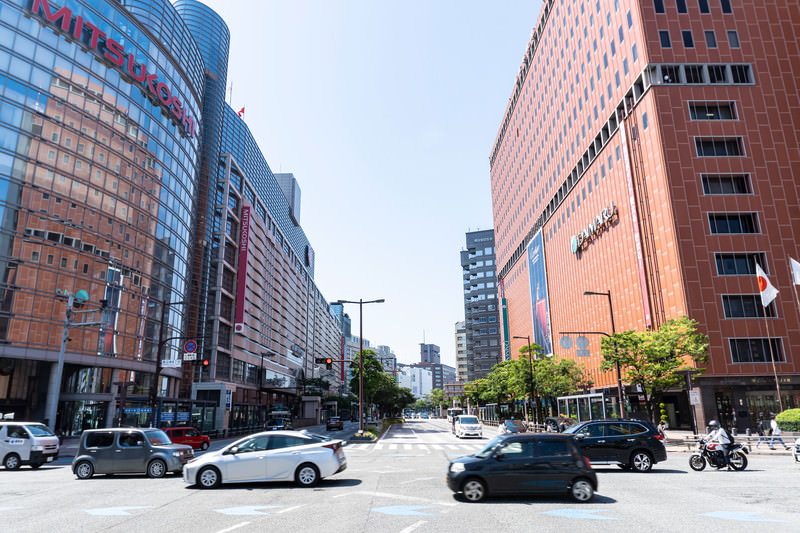

In [27]:
pil_image

In [29]:
import textwrap
print(textwrap.fill(answer, width=120))

The image depicts a busy intersection in a city, likely in Japan, given the architectural style and signage. On the
left, there is a prominent building with a large glass facade, prominently displaying the word "MITSUKO" in red letters.
This building is part of a larger complex with other structures visible in the background.  In the center, there is a
red building with the word "BENRI" visible on its facade. This building is adjacent to a building with a brown facade,
and there are trees lining the street, adding a touch of greenery to the urban setting.  On the right, there is another
building with a reddish-brown exterior. This building has a large glass window and is adjacent to a building with a
brick facade. The street is wide, and there are several cars and motorcycles visible, indicating a busy traffic scene.
Overall, the scene captures a typical day in a city with a mix of modern and traditional architecture, featuring a
variety of vehicles and a well-planned intersection.
